# 实验准备

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from collections import defaultdict, OrderedDict

import nltk
from nltk.tokenize import word_tokenize
from PIL import Image

from transformers import BertModel

In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

如果计算机安装有CUDA，则使用CUDA进行接下来的全部训练，否则使用CPU

In [3]:
# 如果计算机安装有CUDA，则使用CUDA进行接下来的全部训练，否则使用CPU
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('using device:', device)

using device: cuda


根据训练数据查看文本的长度分布

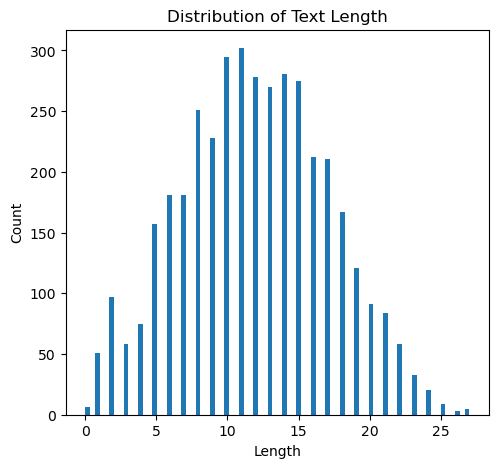

In [4]:
train_set_path = '../dataset/train.txt'
text_path = '../dataset/data/'

train_df = pd.read_csv(train_set_path, index_col=False)
guids = train_df['guid'].values

train_text = []
train_text_len = []

for guid in guids:
    path = text_path + str(guid) + '.txt'
    with open(path, 'r', encoding='utf-8', errors='ignore') as f:
        text = [line.strip() for line in f.readlines() if line.strip()]  # 去除空行
    text = ' '.join(text)
        
    tokens = word_tokenize(text)  # 分词
    tokens = [word for word in tokens if word.isalpha()]  # 去除标点符号和数字
    tokens = [word.lower() for word in tokens]  # 转换为小写字母
    
    train_text.append(tokens)
    train_text_len.append(len(tokens))

plt.hist(train_text_len, bins=80)
plt.title('Distribution of Text Length')
plt.xlabel('Length')
plt.ylabel('Count')

fig_path = "../graph/Distribution of Text Length"
plt.savefig(fig_path)

根据训练数据建立词表

In [5]:
class Vocab:
    def __init__(self, text, min_freq=1, reserved_tokens=None):
        self.idx2token = list()
        self.token2idx = {}
        token_freqs = defaultdict(int)
        self.UNK_TOKEN = '<UNK>'
        
        for sentence in text:
            for token in sentence:
                token_freqs[token] += 1
                
        unique_tokens = [self.UNK_TOKEN]
        if reserved_tokens:
            unique_tokens += reserved_tokens
        # 过滤掉出现频率过低的词
        unique_tokens += [token for token, freq in token_freqs.items() if freq >= min_freq]

        for token in unique_tokens:
            self.idx2token.append(token)
            self.token2idx[token] = len(self.idx2token) - 1
        self.unk = self.token2idx[self.UNK_TOKEN]

    def __len__(self):
        return len(self.idx2token)

    def __getitem__(self, token):
        return self.token2idx.get(token, self.unk)

    def convert_tokens_to_ids(self, tokens):
        return [self[token] for token in tokens]

    def convert_ids_to_tokens(self, ids):
        return [self.idx2token[idx] for idx in ids]

PAD_TOKEN = '<PAD>'
reserved_tokens = [PAD_TOKEN]
vocab = Vocab(train_text, reserved_tokens=reserved_tokens)

划分训练集、验证集、测试集，并转换为Dataloader对象

In [6]:
class SentimentDataset(Dataset):
    def __init__(self, dataframe, text_path):
        self.guids = dataframe['guid'].values
        self.tags = dataframe['tag'].values
        self.text_path = text_path
        self.label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}  # 标签映射

    def __len__(self):
        return len(self.guids)

    def __getitem__(self, index):
        guid = self.guids[index]

        text_path = self.text_path + str(guid) + '.txt'
        with open(text_path, 'r', encoding='utf-8', errors='ignore') as f:
            text = [line.strip() for line in f.readlines() if line.strip()]  # 去除空行
        text = ' '.join(text)
        
        tokens = word_tokenize(text)  # 分词
        tokens = [word for word in tokens if word.isalpha()]  # 去除标点符号和数字
        tokens = [word.lower() for word in tokens]  # 转换为小写字母     
        ids = vocab.convert_tokens_to_ids(tokens)  # 利用词表进行转换
        ids = torch.tensor(ids, dtype=torch.long)
            
        tag = self.tags[index]
        if pd.isna(tag):
            label = 3
        else:
            label = self.label_mapping[tag]

        return ids, label
    
def collate_fn(batch):
    text = [sample[0] for sample in batch]
    padded_text = pad_sequence(text, batch_first=True, padding_value=vocab[PAD_TOKEN])
    attention_mask = (padded_text != vocab[PAD_TOKEN]).type(torch.float32)
    
    labels = torch.tensor([sample[1] for sample in batch], dtype=torch.long)
    
    return padded_text, attention_mask, labels

train_set_path = '../dataset/train.txt'
test_set_path = '../dataset/test_without_label.txt'
text_path = '../dataset/data/'

# 读取训练数据
train_df = pd.read_csv(train_set_path, index_col=False)

# 将训练数据划分为训练集和验证集，固定划分（8:2）
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

# 读取测试数据，即测试集
test_df = pd.read_csv(test_set_path, index_col=False)

num_train = train_df.shape[0]
num_val = val_df.shape[0]
num_test = test_df.shape[0]

print('X_train: ', num_train)
print('X_val: ', num_val)
print('X_test: ', num_test)
print()

train_dataset = SentimentDataset(train_df, text_path)
val_dataset = SentimentDataset(val_df, text_path)
test_dataset = SentimentDataset(test_df, text_path)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)

X_train:  3200
X_val:  800
X_test:  511


查看Dataloader数据格式

In [7]:
for text, attention_mask, labels in train_loader:
    print(text[0])
    print(type(text[0]))
    print(attention_mask[0])
    print(type(attention_mask[0]))
    print(labels[0])
    print(type(labels[0]))
    break

tensor([   2, 1851, 1852, 1427, 1853, 1427, 1854, 1855, 1856, 1852, 1853,  178,
        1857,   18,   18,    1,    1,    1,    1,    1,    1,    1,    1,    1])
<class 'torch.Tensor'>
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.])
<class 'torch.Tensor'>
tensor(1)
<class 'torch.Tensor'>


# 训练并评价模型

定义文本分类模型

In [ ]:
class TextRNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super(TextRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.RNN(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, text, attention_mask):
        embedded_text = self.embedding(text)
        rnn_output, _ = self.rnn(embedded_text)
        output = self.fc(rnn_output[:, -1, :])  # 使用最后一个隐藏层
        return output

class TextLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super(TextLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, text, attention_mask):
        embedded_text = self.embedding(text)
        rnn_output, _ = self.rnn(embedded_text)
        output = self.fc(rnn_output[:, -1, :])  # 使用最后一个隐藏层
        return output
    
class TextGRU(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super(TextGRU, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.GRU(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, text, attention_mask):
        embedded_text = self.embedding(text)
        rnn_output, _ = self.rnn(embedded_text)
        output = self.fc(rnn_output[:, -1, :])  # 使用最后一个隐藏层
        return output

class TextBERT(nn.Module):
    def __init__(self, output_dim):
        super(TextBERT, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased', cache_dir='../model')
        self.fc = nn.Linear(self.bert.config.hidden_size, output_dim)

    def forward(self, text, attention_mask):
        outputs = self.bert(text, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        output = self.fc(pooled_output)
        return output

检查模型准确率

In [9]:
def check_accuracy(model):
    num_correct = 0
    num_samples = 0
    model.eval()
    with torch.no_grad():
        for text, attention_mask, labels in val_loader:
            text = text.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)
            scores = model(text, attention_mask)
            _, preds = scores.max(1)
            num_correct += (preds == labels).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        return acc

训练模型

In [10]:
def train_model(model, optimizer, epochs):
    model.to(device)
    model.train()
    
    train_loss = []
    for epoch in range(epochs):
        total_loss = 0
        for text, attention_mask, labels in train_loader:
            # 将待更新参数的梯度置为零
            optimizer.zero_grad()
            
            text = text.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            scores = model(text, attention_mask)
            
            loss = F.cross_entropy(scores, labels)

            # 反向传播，计算梯度
            loss.backward()

            # 利用梯度更新参数
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / num_train
        print(f'Epoch: {epoch + 1}/{epochs}')
        print(f'Train Loss: {avg_loss}')
        train_loss.append(avg_loss)
        
    val_acc = check_accuracy(model)
    
    return model, train_loss, val_acc

记录训练损失

In [11]:
train_loss_all = dict()

使用RNN作为文本分类模型

In [12]:
best_model = None
best_lr = -1
best_val_acc = -1

vocab_size = len(vocab)
embed_dim = 256
hidden_dim = 512
num_classes = 3

model_type = 'RNN'
learning_rates = [1e-4, 5e-4, 1e-3]

for lr in learning_rates:
    model = TextRNN(vocab_size, embed_dim, hidden_dim, num_classes)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    model, train_loss, val_acc = train_model(model, optimizer, epochs=30)
    key = model_type
    train_loss_all[key] = train_loss
    if val_acc > best_val_acc:
        best_model = model
        best_val_acc = val_acc
        best_lr = lr
    print('model %s lr %e val accuracy: %f' % (model_type, lr, val_acc))
        
print('best validation accuracy achieved:')
print('model %s lr %e val accuracy: %f' % (model_type, best_lr, best_val_acc))
# model RNN lr 1.000000e-03 val accuracy: 0.606250

Epoch: 1/30
Train Loss: 0.0146714954264462
Epoch: 2/30
Train Loss: 0.014276763033121824
Epoch: 3/30
Train Loss: 0.014272417444735765
Epoch: 4/30
Train Loss: 0.014251016974449159
Epoch: 5/30
Train Loss: 0.01428263982757926
Epoch: 6/30
Train Loss: 0.014224940687417984
Epoch: 7/30
Train Loss: 0.014132027141749859
Epoch: 8/30
Train Loss: 0.014166667461395263
Epoch: 9/30
Train Loss: 0.01415717639029026
Epoch: 10/30
Train Loss: 0.014135023914277553
Epoch: 11/30
Train Loss: 0.014061850253492594
Epoch: 12/30
Train Loss: 0.014272416327148676
Epoch: 13/30
Train Loss: 0.01407759377732873
Epoch: 14/30
Train Loss: 0.01407934719696641
Epoch: 15/30
Train Loss: 0.014047102872282266
Epoch: 16/30
Train Loss: 0.014098898600786924
Epoch: 17/30
Train Loss: 0.014083955008536576
Epoch: 18/30
Train Loss: 0.013988184053450823
Epoch: 19/30
Train Loss: 0.013954541068524123
Epoch: 20/30
Train Loss: 0.013864730540663004
Epoch: 21/30
Train Loss: 0.01376483565196395
Epoch: 22/30
Train Loss: 0.013689749408513308
Epoc

使用LSTM作为文本分类模型

In [13]:
best_model = None
best_lr = -1
best_val_acc = -1

vocab_size = len(vocab)
embed_dim = 256
hidden_dim = 512
num_classes = 3

model_type = 'LSTM'
learning_rates = [1e-4, 5e-4, 1e-3]

for lr in learning_rates:
    model = TextLSTM(vocab_size, embed_dim, hidden_dim, num_classes)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    model, train_loss, val_acc = train_model(model, optimizer, epochs=30)
    key = model_type
    train_loss_all[key] = train_loss
    if val_acc > best_val_acc:
        best_model = model
        best_val_acc = val_acc
        best_lr = lr
    print('model %s lr %e val accuracy: %f' % (model_type, lr, val_acc))
        
print('best validation accuracy achieved:')
print('model %s lr %e val accuracy: %f' % (model_type, best_lr, best_val_acc))
# model LSTM lr 1.000000e-03 val accuracy: 0.590000

Epoch: 1/30
Train Loss: 0.014571174941956998
Epoch: 2/30
Train Loss: 0.014296993799507617
Epoch: 3/30
Train Loss: 0.014246158935129642
Epoch: 4/30
Train Loss: 0.014216226413846017
Epoch: 5/30
Train Loss: 0.014215814806520939
Epoch: 6/30
Train Loss: 0.014212152678519488
Epoch: 7/30
Train Loss: 0.014161336310207844
Epoch: 8/30
Train Loss: 0.014100973643362522
Epoch: 9/30
Train Loss: 0.01399027768522501
Epoch: 10/30
Train Loss: 0.01366142312064767
Epoch: 11/30
Train Loss: 0.012824631202965975
Epoch: 12/30
Train Loss: 0.011911136489361525
Epoch: 13/30
Train Loss: 0.010752815399318933
Epoch: 14/30
Train Loss: 0.009905254524201155
Epoch: 15/30
Train Loss: 0.008699653297662735
Epoch: 16/30
Train Loss: 0.007925063939765095
Epoch: 17/30
Train Loss: 0.007290456527844071
Epoch: 18/30
Train Loss: 0.006285188067704439
Epoch: 19/30
Train Loss: 0.005671218484640122
Epoch: 20/30
Train Loss: 0.005134300664067269
Epoch: 21/30
Train Loss: 0.004707728056237101
Epoch: 22/30
Train Loss: 0.004093014970421791

使用GRU作为文本分类模型

In [14]:
best_model = None
best_lr = -1
best_val_acc = -1

vocab_size = len(vocab)
embed_dim = 256
hidden_dim = 512
num_classes = 3

model_type = 'GRU'
learning_rates = [1e-4, 5e-4, 1e-3]

for lr in learning_rates:
    model = TextGRU(vocab_size, embed_dim, hidden_dim, num_classes)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    model, train_loss, val_acc = train_model(model, optimizer, epochs=30)
    key = model_type
    train_loss_all[key] = train_loss
    if val_acc > best_val_acc:
        best_model = model
        best_val_acc = val_acc
        best_lr = lr
    print('model %s lr %e val accuracy: %f' % (model_type, lr, val_acc))
        
print('best validation accuracy achieved:')
print('model %s lr %e val accuracy: %f' % (model_type, best_lr, best_val_acc))
# model GRU lr 5.000000e-04 val accuracy: 0.592500

Epoch: 1/30
Train Loss: 0.014619244784116745
Epoch: 2/30
Train Loss: 0.014237936660647392
Epoch: 3/30
Train Loss: 0.014149579908698797
Epoch: 4/30
Train Loss: 0.014101049210876227
Epoch: 5/30
Train Loss: 0.014030108116567136
Epoch: 6/30
Train Loss: 0.013919027782976627
Epoch: 7/30
Train Loss: 0.013670093081891536
Epoch: 8/30
Train Loss: 0.012987087070941926
Epoch: 9/30
Train Loss: 0.01187818368896842
Epoch: 10/30
Train Loss: 0.010693232947960495
Epoch: 11/30
Train Loss: 0.009303506640717387
Epoch: 12/30
Train Loss: 0.007641985435038805
Epoch: 13/30
Train Loss: 0.006275113713927567
Epoch: 14/30
Train Loss: 0.005153908981010318
Epoch: 15/30
Train Loss: 0.004122237239498645
Epoch: 16/30
Train Loss: 0.0035290223965421317
Epoch: 17/30
Train Loss: 0.0027675224468111993
Epoch: 18/30
Train Loss: 0.002218010815558955
Epoch: 19/30
Train Loss: 0.0017627011012518777
Epoch: 20/30
Train Loss: 0.0017910578835289926
Epoch: 21/30
Train Loss: 0.001532632971648127
Epoch: 22/30
Train Loss: 0.0013653292678

使用BERT作为文本分类模型

In [12]:
best_model = None
best_lr = -1
best_val_acc = -1

vocab_size = len(vocab)
embed_dim = 256
hidden_dim = 512
num_classes = 3

model_type = 'BERT'
learning_rates = [1e-4, 5e-4, 1e-3]

for lr in learning_rates:
    model = TextBERT(num_classes)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    model, train_loss, val_acc = train_model(model, optimizer, epochs=30)
    key = model_type
    train_loss_all[key] = train_loss
    if val_acc > best_val_acc:
        # best_model = model
        best_val_acc = val_acc
        best_lr = lr
    print('model %s lr %e val accuracy: %f' % (model_type, lr, val_acc))
        
print('best validation accuracy achieved:')
print('model %s lr %e val accuracy: %f' % (model_type, best_lr, best_val_acc))
# model BERT lr 1.000000e-03 val accuracy: 0.603750

Epoch: 1/30
Train Loss: 0.0154995197057724
Epoch: 2/30
Train Loss: 0.015183483455330134
Epoch: 3/30
Train Loss: 0.014386502895504236
Epoch: 4/30
Train Loss: 0.01460214564576745
Epoch: 5/30
Train Loss: 0.014478271417319775
Epoch: 6/30
Train Loss: 0.014343866854906082
Epoch: 7/30
Train Loss: 0.014417120162397623
Epoch: 8/30
Train Loss: 0.014625435639172792
Epoch: 9/30
Train Loss: 0.014489972479641438
Epoch: 10/30
Train Loss: 0.014563502985984087
Epoch: 11/30
Train Loss: 0.014381342455744744
Epoch: 12/30
Train Loss: 0.014743026047945022
Epoch: 13/30
Train Loss: 0.014407029636204242
Epoch: 14/30
Train Loss: 0.014418645072728395
Epoch: 15/30
Train Loss: 0.014369881339371204
Epoch: 16/30
Train Loss: 0.01440983396023512
Epoch: 17/30
Train Loss: 0.014436202812939882
Epoch: 18/30
Train Loss: 0.014369498584419488
Epoch: 19/30
Train Loss: 0.014579063132405281
Epoch: 20/30
Train Loss: 0.014493127577006817
Epoch: 21/30
Train Loss: 0.014560477789491415
Epoch: 22/30
Train Loss: 0.01444564811885357
Ep

预测测试集的标签并补全保存

In [ ]:
def predict(model):
    all_preds = []
    
    model.eval()
    with torch.no_grad():
        for text, attention_mask, labels in test_loader:
            text = text.to(device)
            attention_mask = attention_mask.to(device)
            scores = model(text, attention_mask)
            _, preds = scores.max(1)
            all_preds.append(preds.cpu().numpy())
            
    tag = np.concatenate(all_preds)
    label_mapping = {0: 'negative', 1: 'neutral', 2: 'positive'}  # 标签映射
    tag_mapping = []
    for i in range(len(tag)):
        tag_mapping.append(label_mapping[tag[i]])
    
    test_df = pd.read_csv(test_set_path, index_col=False)
    test_df['tag'] = tag_mapping
    result_path = '../result/result_text_model.txt'
    test_df.to_csv(result_path, index=False)

In [ ]:
predict(best_model)